In [2]:
from torch.utils.tensorboard import SummaryWriter
from autoencoder import Mapper, DataLoader, VisionDataset
from torchvision.transforms import ToTensor
from tqdm import tqdm
import torch
from PIL import Image
import numpy as np
from pathlib import Path
from lightning_utils import pil_loader

In [3]:
autoencoder = Mapper.load_from_checkpoint(
    "outputs/bedroom_256_autoencoder/2022-04-05-10-42-05/ckpts/autoencoder-epoch58-step50000.ckpt"
).eval().to("cuda:0")
autoencoder.freeze()

In [4]:
class MyDataset(VisionDataset):
    def __init__(
        self, root: str, transforms=None, transform=None, target_transform=None
    ) -> None:
        super().__init__(root, transforms, transform, target_transform)
        self.pair_filenames = [
            [empty, full]
            for empty, full in zip(
                Path(root).joinpath("empty").rglob("*.png"),
                Path(root).joinpath("full").rglob("*.png"),
            )
        ]

    def rand_num(self):
        return torch.rand(1).item()

    def __getitem__(self, index: int):
        empty, full = self.pair_filenames[index]

        empty = np.array(pil_loader(empty), dtype=np.float32, copy=False) / 255
        full = np.array(pil_loader(full), dtype=np.float32, copy=False) / 255
        image = np.concatenate([empty, full], axis=1)
        image = image * 2 - 1
        if self.transforms is not None:
            image, _ = self.transforms(image, None)

        return image

    def __len__(self) -> int:
        return len(self.pair_filenames)


In [5]:
dataset = DataLoader(
    MyDataset(root="/home/ubuntu/bedroom_256_train/", transform=ToTensor()),
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=False,
)

In [6]:
empty = []
full = []
for x in tqdm(dataset):
    x = x.to("cuda:0")
    z, _ = autoencoder(x)
    B, C, H, W = z.shape

    empty.append(z[:, :, :, :W//2].cpu())
    full.append(z[:, :, :, W//2:].cpu())


100%|██████████| 1753/1753 [02:05<00:00, 14.00it/s]


In [7]:
full = torch.cat(full)
empty = torch.cat(empty)
print(full.shape, empty.shape)

torch.Size([28038, 256, 16, 16]) torch.Size([28038, 256, 16, 16])


In [8]:
def tensor_to_np_img(synth_image):
    synth_image = (synth_image + 1) * (255 / 2)
    return (
        synth_image.permute(0, 2, 3, 1)
        .clamp(0, 255)
        .to(torch.uint8)[0]
        .cpu()
        .numpy()
    )

tensor(0.2792, device='cuda:0') tensor(0.3535, device='cuda:0')


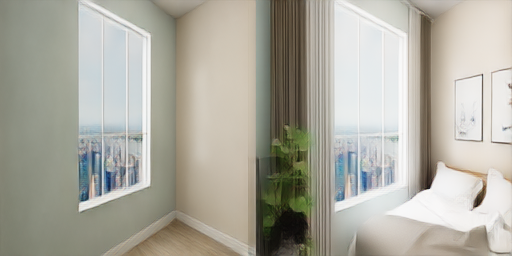

In [9]:
num = 50
vec = (empty - full).mean(0, True)
ori = autoencoder.autoencoder.decoder(
        (
            empty[num:num + 1]
        ).cuda()
)
img = autoencoder.autoencoder.decoder(
        (
            full[num:num + 1] + vec
        ).cuda()
    )
print(ori.mean(), img.mean())
Image.fromarray(
    np.concatenate(
        list(map(tensor_to_np_img, [ori, img])), 1
    )
)

In [11]:
torch.save(vec, "outputs/bedroom_256_autoencoder/2022-04-05-10-42-05/encoded_direction_vec.pt")